<a href="https://colab.research.google.com/github/eTcilopp/geek_brains/blob/main/044_machine_learning/hw06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Работа с данными. Домашнее задание


## Задача
Имеется набор данных покупателей супермаркета. Проведите анализ и очистку этих данных.

### Описание данных

Дан файл Mall_Customers.csv, содержащий следующие данные по покупателям сети супермаркетов:
- CustomerID — идентификатор покупателя.
- Genre – пол покупателя.
- Age – возраст покупателя.
- Annual Income (k\$) – годовой доход покупателя, тысяч $.
- Spending Score (1–100) – рейтинг покупателя, целевая переменная.

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

### Задание 1

Загрузите данные из файла `Mall_Customers.csv` в ноутбук и выведите первые пять строк на экран.

In [137]:
data = pd.read_csv('https://gbcdn.mrgcdn.ru/uploads/asset/6057163/attachment/a0b56ea725f3a8ddc97389674fbb3746.csv')
data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19.0,15.0,39
1,2,Male,NaN,NaN,81
2,3,Female,NaN,16.0,6
3,4,Female,23.0,16.0,77
4,5,Female,31.0,17.0,40


### Задание 2

Проведите разведочный анализ загруженных данных. Обязательные атрибуты для анализа:
- количество пропусков в каждом признаке;
- распределения признаков;
- возможные выбросы или аномалии.

Анализ дополнительных атрибутов и свойств данных приветствуется. Используйте средства визуализации там, где это необходимо.

По результатам анализа сделайте выводы о свойствах отдельных признаков и качестве данных в целом.

## Количества пропусков

### В абсолютных величинах  

In [138]:
data.isna().sum()

,0
CustomerID,0
Genre,19
Age,20
Annual Income (k$),20
Spending Score (1-100),0


### В долях единицы

In [139]:
data.isna().sum()/data.shape[0]

,0
CustomerID,0.000
Genre,0.095
Age,0.100
Annual Income (k$),0.100
Spending Score (1-100),0.000


Исправим опечатку

In [140]:
data = data.rename(columns={'Genre': 'Gender'})

## Распределения признаков

### Графически

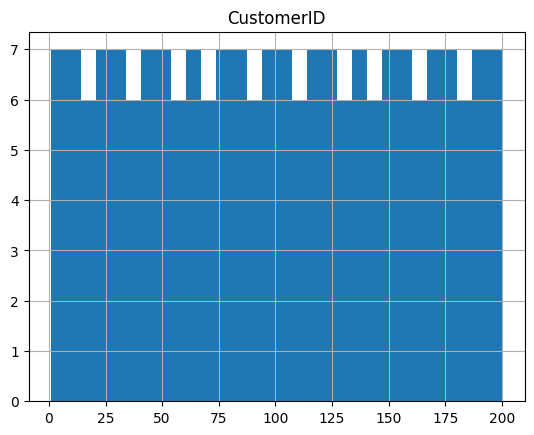

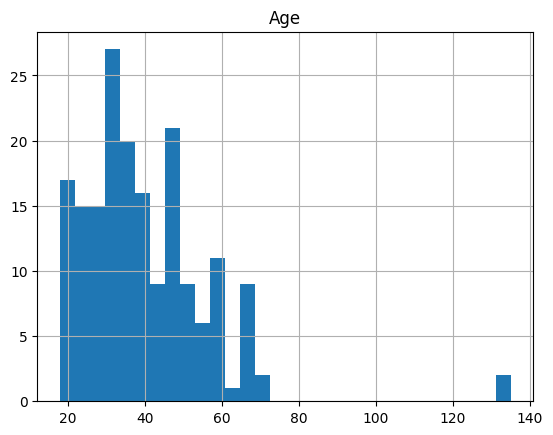

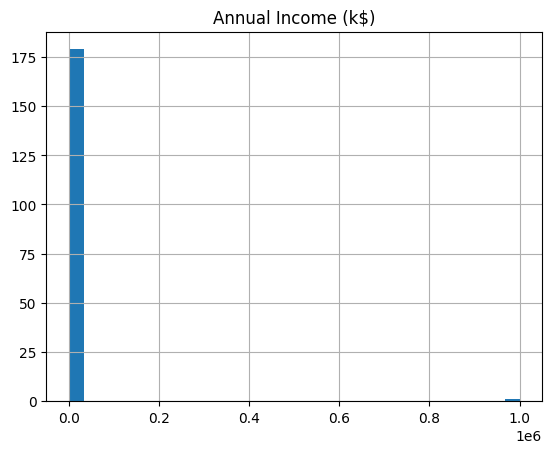

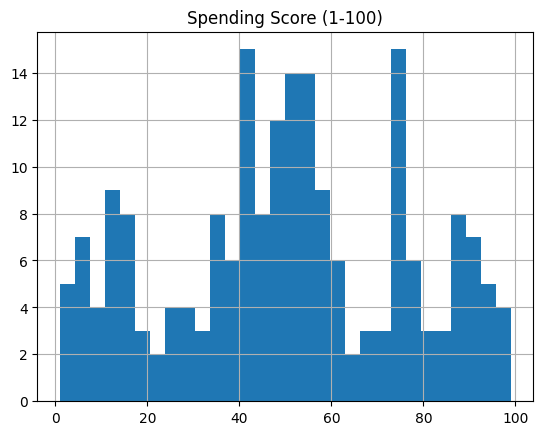

In [141]:
for column in data.select_dtypes(include=['number']).columns:
    data[column].hist(bins=30)
    plt.title(column)
    plt.show()

Распределение ID не имеет смысла,<br>
Распределение возраста и Spending Score можно считать нормальным<br>
Распределение годового дохода непонятно, нужно рассмотреть внимательнее.

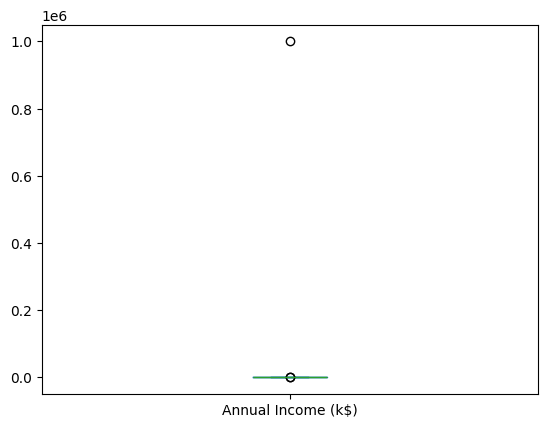

In [142]:
data['Annual Income (k$)'].plot(kind='box')
plt.show();

Похоже, все дело в одном миллионере. Попробуем избавиться от выбросов.

In [143]:
series = data['Annual Income (k$)']
q25 = series.quantile(0.25)
q75 = series.quantile(0.75)
iqr = q75 - q25
lower_bound = q25 - 1.5 * iqr
upper_bound = q75 + 1.5 * iqr

data = data[(data['Annual Income (k$)'] > lower_bound) & (data['Annual Income (k$)'] < upper_bound)]

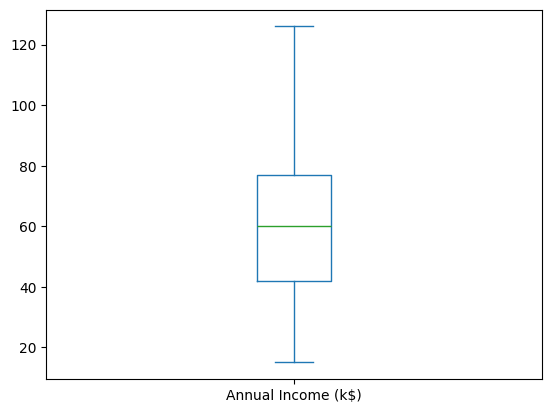

In [144]:
data['Annual Income (k$)'].plot(kind='box')
plt.show();

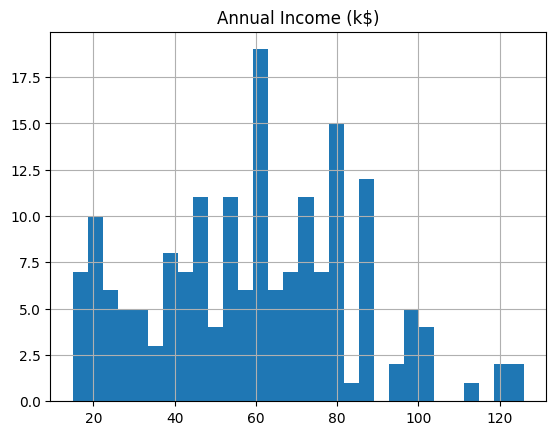

In [145]:
data['Annual Income (k$)'].hist(bins=30)
plt.title('Annual Income (k$)')
plt.show()

Совсем другое дело

### Задание 3

Разделите данные на обучающую и тестовую выборки в пропорции 80:20. Здесь и далее используйте random_state = 1.

In [146]:
X = data[['Gender', 'Age', 'Annual Income (k$)']]
y = data['Spending Score (1-100)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Задание 4

Заполните пропуски в признаках в обучающей выборке с использованием инструментов sklearn. Для каждого признака выберите и аргументируйте стратегию заполнения пропусков.

In [147]:
missing_values = X_train.isna().sum()
filtered = missing_values[missing_values > 0]
filtered

,0
Gender,12
Age,15


## Работа с полом.
Будем исходить из того, что полов 2.
Имеем распределение значений:

In [148]:
X_train['Gender'].value_counts()

,count
Gender,
Female,74
Male,54
Feemale,1


Исправим опечатку

In [149]:
X_train['Gender'] = X_train['Gender'].replace('Feemale', 'Female')

In [150]:
unique_gender_count = X_train['Gender'].value_counts()
unique_gender_count

,count
Gender,
Female,75
Male,54


In [151]:
fem_to_m_ratio = unique_gender_count['Female'] / unique_gender_count['Male']

Имеем соотношение 1.4 женщин на 1 мужчину в выборке. <br>
Можно использовать это же соотношение для заполнения пробелов случайным образом

In [152]:
ratio = [1, fem_to_m_ratio]
n_missing = X_train['Gender'].isna().sum()
choices = np.random.choice(
    ['Male', 'Female'],
    size=n_missing,
    p=[ratio[0] / sum(ratio), ratio[1] / sum(ratio)]
)
X_train['Gender'] = X_train['Gender'].fillna(pd.Series(choices, index=X_train.index[X_train['Gender'].isna()]))

In [153]:
missing_values = X_train.isna().sum()
filtered = missing_values[missing_values > 0]
filtered

,0
Age,15


## Работа с пропусками в возрастах

С полами покончено, <br>
Возраст можно взять медианный, поскольку данный подход не внесет искажений (значительных) в результаты.

In [154]:
s_imputer = SimpleImputer(strategy='median')
X_train['Age'] = s_imputer.fit_transform(X_train[['Age']])

In [155]:
missing_values = X_train.isna().sum()
filtered = missing_values[missing_values > 0]
filtered

,0


### Задание 5

Найдите выбросы в признаках обучающей выборки. Замените выбросы, если таковые имеются, и аргументируйте выбор метода поиска выбросов.


Выброс в доходах мы видели (и испоавили) ранее. <br>
Проверим всю выборку на выбросы.



Для начала разделим выборку опять на обучающую и тестовую: <br>
данные были изменены

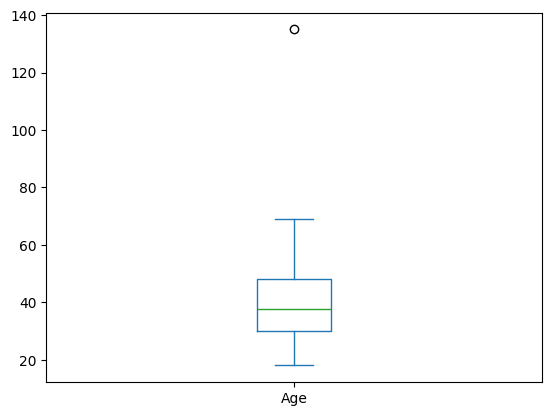

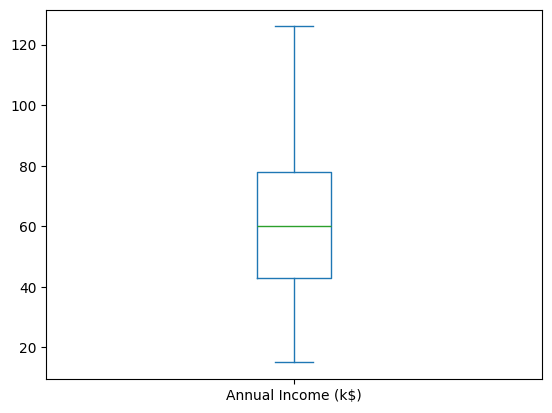

In [156]:
for col in X_train.select_dtypes(include=['number']).columns:
    X_train[col].plot(kind='box')
    plt.show();

Имеем явную ошибку (выброс) в возрастах: люди не живут по 140 лет. <br>
Заменим все значения возрастов > 90 лет на медианные значения <br>
Здесь можно обойтись без квантилей, поскольку доподлинно известен диапазон возможных возрастов.

In [157]:
TARGET_AGE = 120
median_age = X_train.loc[X_train['Age'] <= TARGET_AGE, 'Age'].median()
X_train.loc[X_train['Age'] > TARGET_AGE, 'Age'] = median_age

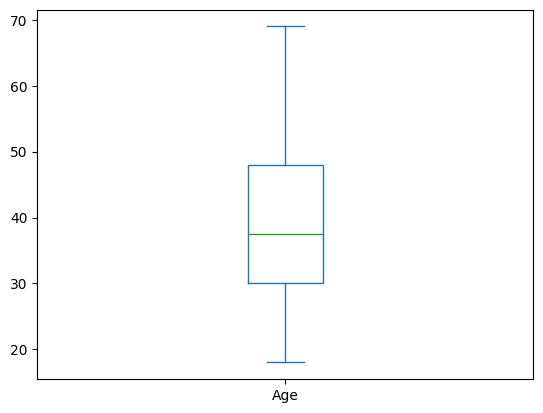

In [158]:
X_train['Age'].plot(kind='box')
plt.show();

### Задание 6

Нормализуйте численные признаки. Аргументируйте выбор стратегии нормализации для каждого признака.


In [159]:
scaler = StandardScaler()
X_train[['Age', 'Annual Income (k$)']] = scaler.fit_transform(X_train[['Age', 'Annual Income (k$)']])

Выбран StandartScaler() потому, что данные наши хорошо подготовлены и не требуют особой обработки.<br>
Стандартное масштабирование - то, что нужно.

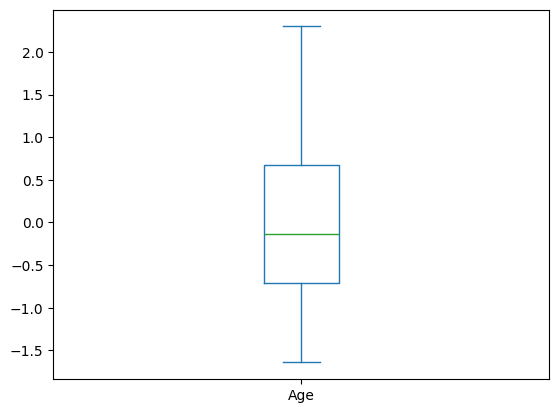

In [160]:
X_train['Age'].plot(kind='box')
plt.show();

### Задание 7

Закодируйте категориальные признаки в обучающей выборке. Аргументируйте выбор способа кодирования.

Категориальный признак у нас только один - Пол. Если пола два (как в нашем кейсе), то лучше применить LabelEncoder, поскольку с двумя значениями мы не получим искусственно созданную линейную зависимость, и не увеличим число измерений за счет новых колонок (как было бы при OneHotEncoding)

In [161]:
encoder = LabelEncoder()
X_train['Gender'] = encoder.fit_transform(X_train['Gender'])
list(enumerate(encoder.classes_))

[(0, 'Female'), (1, 'Male')]

In [162]:
X_train

,Gender,Age,Annual Income (k$)
99,1,-1.487600,0.027380
189,0,-0.251039,1.681884
124,0,-1.255745,0.381916
55,1,0.599096,-0.681694
61,1,-1.564885,-0.563515
...,...,...,...
148,0,-0.405609,0.697060
152,0,0.367241,0.697060
81,1,-0.096469,-0.248371
155,0,-0.946605,0.697060


### Задание 8
Проведите очистку и подготовку тестовых данных. Используйте препроцессоры и другие инструменты, которые вы уже использовали при подготовке обучающей выборки, без их дополнительной настройки.

In [163]:
missing_values = X_test.isna().sum()
filtered = missing_values[missing_values > 0]

X_test['Gender'] = X_test['Gender'].replace('Feemale', 'Female')

unique_gender_count = X_test['Gender'].value_counts()
fem_to_m_ratio = unique_gender_count['Female'] / unique_gender_count['Male']

ratio = [1, fem_to_m_ratio]
n_missing = X_test['Gender'].isna().sum()
choices = np.random.choice(
    ['Male', 'Female'],
    size=n_missing,
    p=[ratio[0] / sum(ratio), ratio[1] / sum(ratio)]
)
X_test['Gender'] = X_test['Gender'].fillna(pd.Series(choices, index=X_test.index[X_test['Gender'].isna()]))

s_imputer = SimpleImputer(strategy='median')
X_test['Age'] = s_imputer.fit_transform(X_test[['Age']])

TARGET_AGE = 120
median_age = X_test.loc[X_test['Age'] <= TARGET_AGE, 'Age'].median()
X_test.loc[X_test['Age'] > TARGET_AGE, 'Age'] = median_age

scaler = StandardScaler()
X_test[['Age', 'Annual Income (k$)']] = scaler.fit_transform(X_test[['Age', 'Annual Income (k$)']])

encoder = LabelEncoder()
X_test['Gender'] = encoder.fit_transform(X_test['Gender'])